# ASSIGNMENT 2 - DEEP LEARNING FOR COMPUTER VISION
# Convolution Networks


The purpose of this assignment is to apply convolution networks (convnets) to image data.

In this assignment, we will accomplish the following:
1. Apply convnets to image data.
2. Explain the relationship between sample sizes and the use of training the convnets from scratch 
versus using a pretrained network.

# Instructions


Convents can be used successfully to classify images. In this assignment, you will examine the relationship between training samples and the choice of training your model from scratch, versus using a pretrained convnet. Specifically, answer the following questions:
1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?
2. Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?
3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.
4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.

Summarize your findings: what is the relationship between training sample 
size and choice of network?

# 1. Developing a network from scratch


We are going to develop a new neural network from scratch with a limited amount of data. Our small dataset is part of the "Dog-vs-Cats" dataset from Kaggle website. Our network is a convolution network, or convnet, that is a particular type of deep learning model suited for computer vision and that, thanks to its properties, provide reasonable results even when it is trained with a limited amount of data.

###Downloading the data

Here we download an API token from a Kaggle personal account so that the algorithm can upload all the necessary data.

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fabriziofiorini","key":"8beb64c1be7e04eb78ae89a98a47349a"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 34.5MB/s]
 99% 537M/543M [00:03<00:00, 164MB/s]
100% 543M/543M [00:03<00:00, 147MB/s]
 95% 258M/271M [00:01<00:00, 141MB/s]
100% 271M/271M [00:02<00:00, 139MB/s]


In [5]:
!unzip -qq train.zip

###Copying images to training, validation, and test directories

Now that the dataset is loaded, we can create subsets of it for our training, validation, and test data. Specifically, we use 1000 images for the training set, 500 for the validation set, and 500 for the test set.

In [7]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_1")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

###Instantiating convnet for classification

Let us look at the structure of our convnet. Since the input of this network is made of 3D tensor (images of a certain length, width, color), we need to first rescaling the data to a value between 0 and 1.

After the first layer, we use a series of convolution with a window size of 3x3 and maxpooling with a 2x2 window. Notice that throughout the network the number of filters (depth) increases, the size of the windows remain equal, and the size of the feature maps decrease.

This problem is a binary classification problem, therefore as final layer we use a dense layer that give us the probability that the output is classified as a "cat" or as a "dog". It has one output node, either "cat" or "dog". In order to feed the dense layer, we first need a layer that flatten the 3D shape in 1D

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

From the model summary we can see the network structure and that we have a total of more than 991,000 parameters to optimize. Convolution networks easily tend to overfit, so we should use regularization techniques. 

Let us start with training the model on the training set.

In [10]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

###Data preprocessing

The following code will automatically convert all the images to tensors.

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


###Fitting the model using a Dataset

Let us now fit the model with the training set. We use "callbacks" because it will automatically store a file containing the weights generating from the best epoch. 

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 183s 3s/step - loss: 0.7266 - accuracy: 0.5125 - val_loss: 0.6924 - val_accuracy: 0.5110
Epoch 2/10
63/63 [==============================] - 179s 3s/step - loss: 0.7124 - accuracy: 0.5435 - val_loss: 0.6855 - val_accuracy: 0.5090
Epoch 3/10
63/63 [==============================] - 179s 3s/step - loss: 0.6824 - accuracy: 0.5715 - val_loss: 0.6461 - val_accuracy: 0.6290
Epoch 4/10
63/63 [==============================] - 176s 3s/step - loss: 0.6622 - accuracy: 0.6255 - val_loss: 0.6466 - val_accuracy: 0.6360
Epoch 5/10
63/63 [==============================] - 175s 3s/step - loss: 0.6382 - accuracy: 0.6570 - val_loss: 0.6182 - val_accuracy: 0.6550
Epoch 6/10
63/63 [==============================] - 174s 3s/step - loss: 0.5648 - accuracy: 0.7160 - val_loss: 0.5976 - val_accuracy: 0.6700
Epoch 7/10
63/63 [==============================] - 178s 3s/step - loss: 0.5448 - accuracy: 0.7410 - val_loss: 0.5813 - val_accuracy: 0.6880
Epoch 8/10
63

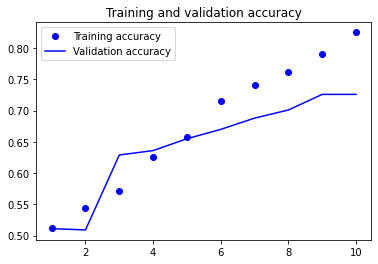

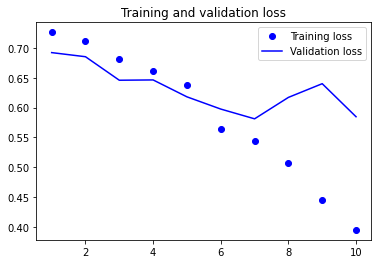

In [11]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

After 10 epochs, we see that the best accuracy is obtained during the fourth epoch and it is equal to 72.6%. Running the model for more epochs can lead to better results.

###Evaluating the model on the test set

Now we run the model on the test set to see what accuracy we obtain from our network.

In [12]:
test_model = keras.models.load_model("convnet_from_scratch1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 21s 631ms/step - loss: 0.6116 - accuracy: 0.6770
Test accuracy: 0.677


Accuracy on the test set from the model with no data augmentation using the first partition of data is equal to 67.7%.

###Defining a data augmentation stage to add to an image model

We are going to use data augmentation to improve the accuracy of our model. Data augmentation allow us to obtain good results even with small datasets because it generate more data from the existing training sample by applying random transformations. The model will never see the same exact image twice.

In this case for example, we randomly flip, rotate, and zoom the images so that they are slightly different from the images already contained in the training data.

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

###Defining a new convnet that includes image augmentation and dropout

Now we add the data augmentation step to our network at the beginning. In order to prevent overfitting, we also add dropout as the last layer before feeding the dense layer.

In [14]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

###Training the regularized convnet

Let us fit the model again.

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 179s 3s/step - loss: 0.7131 - accuracy: 0.5085 - val_loss: 0.7069 - val_accuracy: 0.5000
Epoch 2/10
63/63 [==============================] - 176s 3s/step - loss: 0.6953 - accuracy: 0.5455 - val_loss: 0.6809 - val_accuracy: 0.5080
Epoch 3/10
63/63 [==============================] - 176s 3s/step - loss: 0.7061 - accuracy: 0.5800 - val_loss: 0.6608 - val_accuracy: 0.5720
Epoch 4/10
63/63 [==============================] - 178s 3s/step - loss: 0.6785 - accuracy: 0.6285 - val_loss: 0.6800 - val_accuracy: 0.6010
Epoch 5/10
63/63 [==============================] - 178s 3s/step - loss: 0.6373 - accuracy: 0.6450 - val_loss: 0.5960 - val_accuracy: 0.6830
Epoch 6/10
63/63 [==============================] - 178s 3s/step - loss: 0.6154 - accuracy: 0.6625 - val_loss: 0.6211 - val_accuracy: 0.6810
Epoch 7/10
63/63 [==============================] - 178s 3s/step - loss: 0.6063 - accuracy: 0.6765 - val_loss: 0.5792 - val_accuracy: 0.6960
Epoch 8/10
63

The best validation accuracy is reached at epoch 10 with 72.2%.

###Evaluating the model on the test set

In [16]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 20s 622ms/step - loss: 0.5745 - accuracy: 0.7080
Test accuracy: 0.708


Accuracy on the test set from the model with data augmentation using the first partition of data is equal to 70.8%. We obtained a slightly better result. 

From the output we can see that data augmentation has not given an improvement on the model performance. In general, this first approach would always limited by the amount of initial data. We will see in section 4 that we can avoid this by using a pretrained network.

# 2. Increasing the training sample size

Now, let us try to improve the model by increasing the training sample size from 1000 to 1500. Both validation set and test set sizes will not change from the first data partition. This is our second data partition.

In [17]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [18]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [19]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [20]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 245s 3s/step - loss: 0.7305 - accuracy: 0.5070 - val_loss: 0.6984 - val_accuracy: 0.5000
Epoch 2/10
94/94 [==============================] - 243s 3s/step - loss: 0.6838 - accuracy: 0.5857 - val_loss: 0.6352 - val_accuracy: 0.6730
Epoch 3/10
94/94 [==============================] - 244s 3s/step - loss: 0.6255 - accuracy: 0.6550 - val_loss: 0.7190 - val_accuracy: 0.6130
Epoch 4/10
94/94 [==============================] - 247s 3s/step - loss: 0.5862 - accuracy: 0.6940 - val_loss: 0.5906 - val_accuracy: 0.6810
Epoch 5/10
94/94 [==============================] - 245s 3s/step - loss: 0.5454 - accuracy: 0.7333 - val_loss: 0.5705 - val_accuracy: 0.6880
Epoch 6/10
94/94 [==============================] - 244s 3s/step - loss: 0.4943 - accuracy: 0.7610 - val_loss: 0.6393 - val_accuracy: 0.7140
Epoch 7/10
94/94 [==============================] - 246s 3s/step - loss: 0.4518 - accuracy: 0.7913 - val_loss: 0.5555 - val_accuracy: 0.7150
Epoch 8/10
94

In [21]:
test_model = keras.models.load_model(
    "convnet_from_scratch2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 21s 630ms/step - loss: 0.5199 - accuracy: 0.7670
Test accuracy: 0.767


Here validation accuracy reached 74.4%. Accuracy on the test set from the model with no data augmentation using the second partition of data is equal to 76.7%. This is the best result so far. However, by using more data for the training phase, we improved the model.

Let us now add a data augmentation layer to the network.

In [22]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [23]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 260s 3s/step - loss: 0.6944 - accuracy: 0.5117 - val_loss: 0.6901 - val_accuracy: 0.5800
Epoch 2/10
94/94 [==============================] - 260s 3s/step - loss: 0.6889 - accuracy: 0.5420 - val_loss: 0.6743 - val_accuracy: 0.6020
Epoch 3/10
94/94 [==============================] - 261s 3s/step - loss: 0.6732 - accuracy: 0.5893 - val_loss: 0.6665 - val_accuracy: 0.6050
Epoch 4/10
94/94 [==============================] - 265s 3s/step - loss: 0.6573 - accuracy: 0.6170 - val_loss: 0.6267 - val_accuracy: 0.6500
Epoch 5/10
94/94 [==============================] - 268s 3s/step - loss: 0.6341 - accuracy: 0.6463 - val_loss: 0.6361 - val_accuracy: 0.6270
Epoch 6/10
94/94 [==============================] - 261s 3s/step - loss: 0.6037 - accuracy: 0.6757 - val_loss: 0.5935 - val_accuracy: 0.6780
Epoch 7/10
94/94 [==============================] - 258s 3s/step - loss: 0.5691 - accuracy: 0.6987 - val_loss: 0.5678 - val_accuracy: 0.6950
Epoch 8/10
94

In [25]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 24s 736ms/step - loss: 0.5037 - accuracy: 0.7600
Test accuracy: 0.760


Validation accuracy is now 73.5%, as we can see from the output of epoch 10. Accuracy on the test set from the model with data augmentation using the second partition of data is equal to 76.0%. Again, adding data augmentation to the model has a very small effect on improving the accuracy rate. In this case, we experienced a decrease of 0.7% compared to the model without data augmentation.

# 3. Finding the ideal training sample size

Since we obtained better results by increasing the training sample size, now we are going to modify the amount of data in the validation set. We set the training, validation, and test set sizes, respectively, to 1500, 1000, and 500.

In [26]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

In [27]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [28]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 352s 4s/step - loss: 0.7234 - accuracy: 0.5413 - val_loss: 0.6873 - val_accuracy: 0.5205
Epoch 2/10
94/94 [==============================] - 348s 4s/step - loss: 0.6785 - accuracy: 0.6123 - val_loss: 0.6674 - val_accuracy: 0.6135
Epoch 3/10
94/94 [==============================] - 285s 3s/step - loss: 0.6163 - accuracy: 0.6633 - val_loss: 0.6216 - val_accuracy: 0.6805
Epoch 4/10
94/94 [==============================] - 286s 3s/step - loss: 0.5813 - accuracy: 0.7023 - val_loss: 0.5740 - val_accuracy: 0.6945
Epoch 5/10
94/94 [==============================] - 277s 3s/step - loss: 0.5222 - accuracy: 0.7397 - val_loss: 0.5938 - val_accuracy: 0.7170
Epoch 6/10
94/94 [==============================] - 272s 3s/step - loss: 0.4735 - accuracy: 0.7727 - val_loss: 0.6736 - val_accuracy: 0.6870
Epoch 7/10
94/94 [==============================] - 273s 3s/step - loss: 0.4229 - accuracy: 0.8027 - val_loss: 0.6469 - val_accuracy: 0.6965
Epoch 8/10
94

In [30]:
test_model = keras.models.load_model(
    "convnet_from_scratch3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 21s 641ms/step - loss: 0.6289 - accuracy: 0.7350
Test accuracy: 0.735


With the third partition, we otained a validation accuracy of 75.65% while the accuracy on the test set is equal to 73.5%.

Let us now add a data augmentation layer to the network.

In [31]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [32]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [33]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 283s 3s/step - loss: 0.6934 - accuracy: 0.5320 - val_loss: 0.6788 - val_accuracy: 0.5845
Epoch 2/10
94/94 [==============================] - 278s 3s/step - loss: 0.6683 - accuracy: 0.6037 - val_loss: 0.6598 - val_accuracy: 0.6050
Epoch 3/10
94/94 [==============================] - 275s 3s/step - loss: 0.6545 - accuracy: 0.6213 - val_loss: 0.6550 - val_accuracy: 0.6175
Epoch 4/10
94/94 [==============================] - 275s 3s/step - loss: 0.6308 - accuracy: 0.6513 - val_loss: 0.6384 - val_accuracy: 0.6445
Epoch 5/10
94/94 [==============================] - 277s 3s/step - loss: 0.6152 - accuracy: 0.6663 - val_loss: 0.6008 - val_accuracy: 0.6845
Epoch 6/10
94/94 [==============================] - 276s 3s/step - loss: 0.5942 - accuracy: 0.6873 - val_loss: 0.5874 - val_accuracy: 0.6920
Epoch 7/10
94/94 [==============================] - 283s 3s/step - loss: 0.5687 - accuracy: 0.7080 - val_loss: 0.5720 - val_accuracy: 0.7200
Epoch 8/10
94

In [34]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 21s 657ms/step - loss: 0.5575 - accuracy: 0.7240
Test accuracy: 0.724


Accuracy on the validation set is 73.45%. Accuracy on the test set from the model with data augmentation using the third partition of data is equal to 72.4%. 

We did not improve our model's performance by increasing the validation sample size. Hence, considering our different versions of the model we developed from scratch, we reached the best accuracy with the two models trained with the second partition: 1500 on training set, 500 on validation set, and 500 on test set.


# 4. Using a pretrained network

For the last section of the assignment we want to use a pretrained network, that is a network that was previously trained on a large dataset. If this original dataset is large enough and general enough, then the pretrained network can effectively act as a generic model and its features can prove useful for many different computer vision problems. Such portability of learned features across different problems is a key advantage of deep learning compared to other machine learning approaches.

Let us consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1,000 different classes). ImageNet contains many animal classes, including different species of cats and dogs. The architecture of the network is called VGG16. It’s a simple and widely used convnet architecture for ImageNet.

There are two ways to use a pretrained network: 
- feature extraction
- fine-tuning

In this assignment, we are going to apply feature extraction, first without data augmentation and then including it to reach even better results.

###Feature extraction - Instantiating the VGG16 convolutional base

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch. In other words, we are going to use the convolutional base, that is the series of pooling and convolution layers we had in our network, and then pass the output on a densely connected classifier that we choose.

In [12]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
______________________________________________________________

This convolutional base has 14.7 million parameters. Notice that we started with the same input we used previously, 3D tensors of shape (180, 180, 3), and we ended up with a tensor of shape (5, 5, 512).

###Feature extraction - Extracting features and corresponding labels

Here we preprocess the images before they are sent to the pretrained network. We can check the shape of the output and see that it corrisponds to what we saw in the network structure: (5, 5, 512)

In [13]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

train_features.shape

KeyboardInterrupt: ignored

###Feature extraction - Defining and training the densely connected classifier

Now that we used the convolutional base of the pretrained network, we can feed the dense layer and train it. Notice that shape of the input in the following code is the same of the output of the convolutional base.

In [37]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extractionPT1.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=15,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/15
94/94 [==============================] - 5s 52ms/step - loss: 15.2194 - accuracy: 0.9330 - val_loss: 3.3935 - val_accuracy: 0.9725
Epoch 2/15
94/94 [==============================] - 5s 51ms/step - loss: 3.0662 - accuracy: 0.9790 - val_loss: 4.0633 - val_accuracy: 0.9745
Epoch 3/15
94/94 [==============================] - 5s 52ms/step - loss: 1.4064 - accuracy: 0.9873 - val_loss: 3.9202 - val_accuracy: 0.9715
Epoch 4/15
94/94 [==============================] - 5s 53ms/step - loss: 1.4706 - accuracy: 0.9910 - val_loss: 10.0884 - val_accuracy: 0.9590
Epoch 5/15
94/94 [==============================] - 5s 50ms/step - loss: 1.1365 - accuracy: 0.9920 - val_loss: 4.6114 - val_accuracy: 0.9780
Epoch 6/15
94/94 [==============================] - 5s 50ms/step - loss: 0.5924 - accuracy: 0.9943 - val_loss: 5.0588 - val_accuracy: 0.9770
Epoch 7/15
94/94 [==============================] - 5s 51ms/step - loss: 0.3519 - accuracy: 0.9973 - val_loss: 5.8654 - val_accuracy: 0.9750
Epoch 8/15


###Feature extraction - Plotting the results

From the results we see that the accuracy improved notably from the performance we obtained when we trained a model from scratch using our limited dataset.

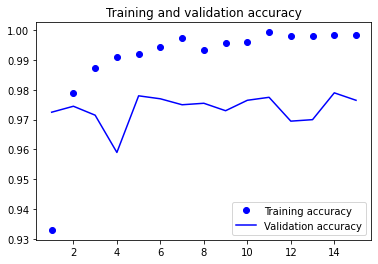

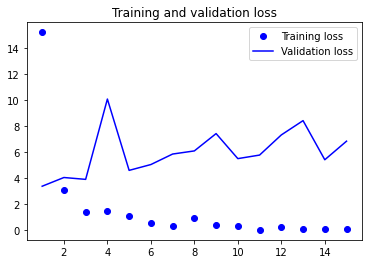

In [38]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [39]:
test_model = keras.models.load_model(
    "feature_extractionPT1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

OSError: ignored

###Feature extraction with Data Augmentation

Let us now add a data augmentation layer to the network.

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentationPT2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=callbacks)

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentationPT2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

# Conclusions

We saw that the performance of the models we created depends on different factors. The biggest impact is given by the initial choice of either training a model from scratch or using a pretrained model. Even with the best configuration of the model we created, it is unlikely that it can achieve the accuracy we saw with the pretrained network.

However, we were able to reach a decent performance even if we trained the model with a very small amount of data. From the different configurations, it seems that the biggest impact on the performance is given by a larger training set (second and third partitions) but not by a larger validation set (third partition). We could try to develop our model using other partitions and check if it is possible to get a better result. Another way to further improve our network is to increase the number of epochs, since we saw from the plot that the validation accuracy was still improving, even if marginally. Finally, it is possible that modifying the network structure (number of layers, type of loss metric, activation functions) it leads to a better performance.

The data augmentation technique helped us on the first data partition (+3.1%), when the training set size was particularly small. When we increased its size, it became less relevant on improving the accuracy of the model. 